In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style('dark')
from scipy import stats
import datetime as dt

%matplotlib inline

### Read NDVI

In [2]:
ds=xr.open_mfdataset(
    '/g/data/oe9/user/rg6346/VI_mask_nc/NDVI/NDVI_????.nc') 
ds=ds.rename({'ndvi_evi':'ndvi'})
ds=ds.drop('band')
ds['ndvi'] = ds.ndvi/10000
ds

<xarray.Dataset>
Dimensions:  (lat: 3147, long: 3344, time: 388)
Coordinates:
  * lat      (lat) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * long     (long) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, lat, long) float64 dask.array<shape=(388, 3147, 3344), chunksize=(20, 3147, 3344)>

### Resample to monthly

In [3]:
NDVI_month=ds.ndvi.resample(time='1M').mean(dim='time')
# ndvi_jja=ndvi_q.where(ndvi_q['time.season']=='JJA',drop=True)
# ndvi_djf=ndvi_q.where(ndvi_q['time.season']=='DJF',drop=True)

In [4]:
NDVI_month

<xarray.DataArray 'ndvi' (time: 203, lat: 3147, long: 3344)>
dask.array<shape=(203, 3147, 3344), dtype=float64, chunksize=(1, 3147, 3344)>
Coordinates:
  * time     (time) datetime64[ns] 2000-02-29 2000-03-31 2000-04-30 ...
  * lat      (lat) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * long     (long) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...

In [5]:
NDVI_month.time[-1]

<xarray.DataArray 'time' ()>
array(1483142400000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-12-31

### Read SPI

In [6]:
spi_1M= xr.open_dataarray('/g/data/oe9/project/team-drip/Rainfall/SPI_awap/SPI_1M_masked.nc')
spi_1M

<xarray.DataArray 'SPI_1M' (latitude: 263, longitude: 280, time: 216)>
[15906240 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 2000-03-01 ...

In [7]:
spi_1M_sub=spi_1M.isel(time=range(1,204))
spi_1M_sub

<xarray.DataArray 'SPI_1M' (latitude: 263, longitude: 280, time: 203)>
[14948920 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 2000-04-01 ...

In [8]:
NDVI_month['time']=spi_1M_sub.time.values

In [9]:
NDVI_month

<xarray.DataArray 'ndvi' (time: 203, lat: 3147, long: 3344)>
dask.array<shape=(203, 3147, 3344), dtype=float64, chunksize=(1, 3147, 3344)>
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-03-01 2000-04-01 ...
  * lat      (lat) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * long     (long) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...

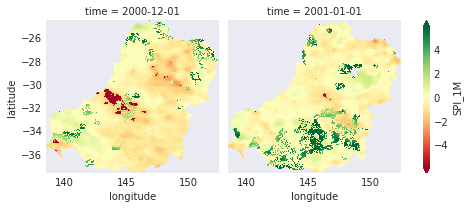

In [10]:
spi_1M_sub.isel(time=range(10,12)).plot.imshow(col='time', robust = True, cmap = 'RdYlGn')

In [11]:
# NDVI_month.isel(time=range(10,12)).plot.imshow(col='time', robust = True, col_wrap=2, cmap = 'RdYlGn')

In [14]:
# TODO: use scipy.image.ndzoom to upscale soil moisture
from scipy.ndimage import zoom as ndzoom
from scipy.misc import imresize as ndresize
# help(ndzoom)

In [15]:
# from copy import deepcopy

# fine_spi = deepcopy(NDVI_month)
# fine_spi.attrs = spi_1M_sub.attrs
# fine_spi.name = spi_1M_sub.name
# fine_spi['time'] = spi_1M_sub.time

# SPLINE_ORDER = 3  # Try some other values 0 to 5 for SPLINE_ORDER to see what happens



# ZOOM_FACTOR = (len(NDVI_month.lat) / len(spi_1M_sub.latitude),
#                len(NDVI_month.long) / len(spi_1M_sub.longitude))

In [16]:
from copy import deepcopy

coarse_NDVI= deepcopy(spi_1M_sub)
coarse_NDVI.attrs = NDVI_month.attrs
coarse_NDVI.name = NDVI_month.name
coarse_NDVI['time'] = NDVI_month.time

SPLINE_ORDER = 3  # Try some other values 0 to 5 for SPLINE_ORDER to see what happens



ZOOM_FACTOR = (len(spi_1M_sub.latitude)/len(NDVI_month.lat),
               len(spi_1M_sub.longitude)/len(NDVI_month.long) )

In [18]:
shape=coarse_NDVI.isel(time=0).shape
type(shape)

tuple

/g/data/oe9/software/anaconda/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 3min 53s, sys: 8min 24s, total: 12min 18s
Wall time: 13min 4s


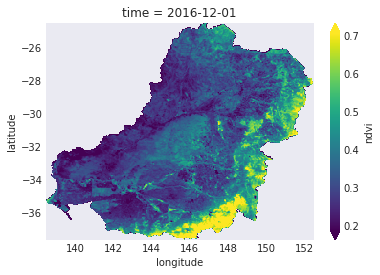

In [19]:
%%time 
# It's also possible to zoom a 3D array by setting a factor of 1 for the time
# dimension, but this way we preserve the timesteps correctly.
for timestamp in coarse_NDVI.time:
    # Start by selecting the timestamp
    data = NDVI_month.sel(time=timestamp)
    # Then zoom to the desired scale, filling nodata values with zero so we can zoom
    output = ndresize(np.nan_to_num(data), shape, interp='cubic',mode = 'F')
    # Assign output to the contents of the fine_moisture array
    coarse = coarse_NDVI.sel(time=timestamp)
    coarse[:] = output
    
    # Make sure the minimum is zero, so it remains physically plausible
    coarse.values[coarse.values < 0] = 0
    # Last, we'll copy both sets of NaN values so that we don't cause spurious correlations
    # Try commenting each of these out to see how the map changes!
    coarse.values[np.isnan(spi_1M_sub.sel(time=timestamp).values)] = np.nan  # from the high-res data
    #coarse.values[ndzoom(np.isnan(data), zoom=ZOOM_FACTOR, order=0)] = np.nan  # from low-res, with nearest (blocky) zooming

coarse_NDVI.isel(time=-1).plot.imshow(robust=True)

In [20]:
NDVI_month

<xarray.DataArray 'ndvi' (time: 203, lat: 3147, long: 3344)>
dask.array<shape=(203, 3147, 3344), dtype=float64, chunksize=(1, 3147, 3344)>
Coordinates:
  * time     (time) datetime64[ns] 2000-02-01 2000-03-01 2000-04-01 ...
  * lat      (lat) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * long     (long) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...

In [21]:
coarse_NDVI

<xarray.DataArray 'ndvi' (latitude: 263, longitude: 280, time: 203)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 

In [108]:
spi_1M_sub

<xarray.DataArray 'SPI_1M' (latitude: 263, longitude: 280, time: 203)>
[14948920 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 2000-04-01 ...

In [22]:
# save the coarse_NDVI into a nc file 
path = '/g/data/oe9/project/team-drip/resampled_NDVI/coarse_NDVI.nc'
coarse_NDVI.to_netcdf(path, mode = 'w')

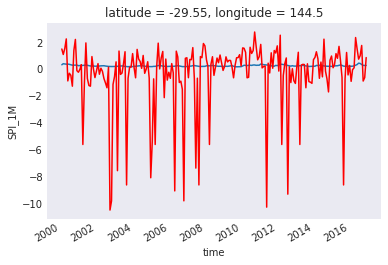

In [126]:
# Try a few different values to see if the relationship holds
_lat, _lon = 100, 120

# To plot two lines on the same axes, we have to explicitly create and use a set of axes 
# For the second, `ax.twinx()` creates a clone of the axes with a shared x and independent y.
fig, ax = plt.subplots()
coarse_NDVI.isel(latitude=100,longitude=120).plot(ax=ax)
spi_1M_sub.isel(latitude=_lat, longitude=_lon).plot(ax=ax, color='red')

In [127]:

# Create an empty dataframe to hold our columns of data
df = pd.DataFrame()
# Convert each data array into a series, and add it to the dataframe
for data in [coarse_NDVI, spi_1M_sub]:
    df[data.name] = data.to_series()
# Discard any rows with missing values - I would usually keep them,
# but we can't correlate anything with missing data
df = df.dropna()

# And examine the first five rows
df.head(5)

ndvi    SPI_1M
latitude longitude time                          
-24.6    146.75    2000-02-01  0.649693  0.137168
                   2000-03-01  0.675545  5.515968
                   2000-04-01  0.704562  0.936391
                   2000-05-01  0.684618  6.809936
                   2000-06-01  0.701135  0.570507

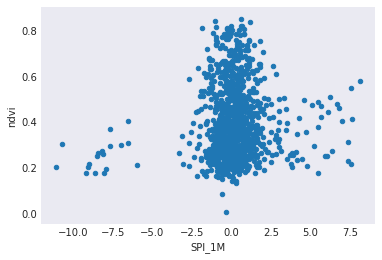

In [129]:
# Try sample numbers between 1 and 100,000; or even delete ".sample()"
df.sample(1000).plot.scatter(x='SPI_1M', y='ndvi')

OverflowError: cannot convert float infinity to integer

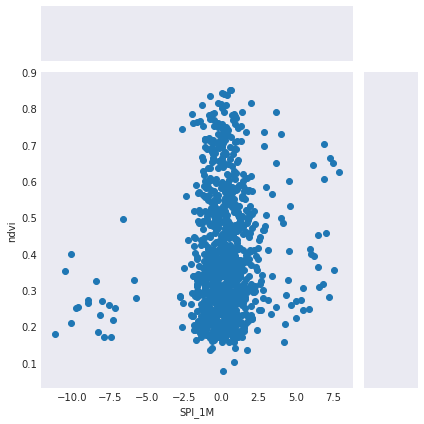

In [136]:

seaborn.jointplot(
    x='SPI_1M',
    y='ndvi',
    data=df.sample(1000),
    # There are several ways to represent a join distribution.
    # Try un-commenting one kind at a time!
    #kind='hex', joint_kws=dict(gridsize=30),
    # kind='kde', cmap='magma_r', n_levels=200,
    kind='scatter',
)